Data

In [1]:
%%shell
rm -rf deep-aerial/
git clone https://github.com/yann-ro/deep-aerial.git

Cloning into 'deep-aerial'...
remote: Enumerating objects: 290, done.
remote: Counting objects: 100% (290/290), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 290 (delta 157), reused 212 (delta 90), pack-reused 0
Receiving objects: 100% (290/290), 16.64 MiB | 12.24 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [2]:
%%shell
rm -rf data/
./deep-aerial/dataset/setup/setup_ir.sh

--2023-03-16 14:06:34--  https://drive.google.com/uc?export=download&id=1AYKP7N8d-RR_hY5jEM3qxF1n0CGsnUkd&confirm=yes
Resolving drive.google.com (drive.google.com)... 172.217.194.139, 172.217.194.113, 172.217.194.138, ...
Connecting to drive.google.com (drive.google.com)|172.217.194.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ut7a4mefnpl27q5nb104092j99of7oc5/1678975575000/01749253850259784187/*/1AYKP7N8d-RR_hY5jEM3qxF1n0CGsnUkd?e=download&uuid=653e2c3e-d602-4489-b8a4-d8571aecfcc8 [following]
--2023-03-16 14:06:35--  https://doc-0o-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ut7a4mefnpl27q5nb104092j99of7oc5/1678975575000/01749253850259784187/*/1AYKP7N8d-RR_hY5jEM3qxF1n0CGsnUkd?e=download&uuid=653e2c3e-d602-4489-b8a4-d8571aecfcc8
Resolving doc-0o-3c-docs.googleusercontent.com (doc-0o-3c-docs.googleusercontent.com)... 74.12

In [3]:
%load_ext autoreload
%autoreload 2

import torch
from torchvision import transforms
from tqdm.notebook import tqdm
import sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("deep-aerial")
from dataset.core import InstCOCODataset
from model.display_pred_inst import display_img_with_bbox
from model.inst_model import InstModel, get_model_inst

train_data_dir = 'data/hit-uav/train/images'
train_coco = 'data/hit-uav/train/labels.json'
val_data_dir = 'data/hit-uav/val/images'
val_coco = 'data/hit-uav/val/labels.json'
test_data_dir = 'data/hit-uav/test/images'
test_coco = 'data/hit-uav/test/labels.json'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [5]:
tfm = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

swim_dataset_train = InstCOCODataset(
    root = train_data_dir,
    annotation = train_coco,
    transforms = tfm
)

swim_dataset_val = InstCOCODataset(
    root = val_data_dir,
    annotation = val_coco,
    transforms = tfm
)

swim_dataset_test = InstCOCODataset(
    root = test_data_dir,
    annotation = test_coco,
    transforms = tfm
)

train_batch_size = 4

data_loader = torch.utils.data.DataLoader(
    swim_dataset_train,
    batch_size = train_batch_size,
    shuffle = True, 
    num_workers = 2,
    collate_fn = collate_fn
)

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [6]:
import numpy as np
from matplotlib import patches, patheffects

def add_bbox(ax, bbox, conf=None, color="red"):
    bbox = np.array(bbox.cpu().detach(), dtype=np.float32)
    ax.add_patch(
        patches.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            color=color,
            fill=False,
            lw=1,
        )
    )
    if conf:
        ax.text(
            bbox[0] + 2,
            (bbox[1] - 7),
            f"{float(conf):.3f}",
            verticalalignment="top",
            color="white",
            fontsize=10,
            weight="bold",
        ).set_path_effects(
            [patheffects.Stroke(linewidth=2, foreground="black"), patheffects.Normal()]
        )


def display_img_with_bbox(ax, img, labels, legend=None, from_pred=False, threshold=0):
    ax.imshow(img)
    ax.axis("off")

    if from_pred:
        for bbox, label, score in zip(
            labels["boxes"], labels["labels"], labels["scores"]
        ):
            if score >= threshold:
                add_bbox(ax, bbox, score)
    else:
        for bbox, label in zip(labels["boxes"], labels["labels"]):
            add_bbox(ax, bbox)

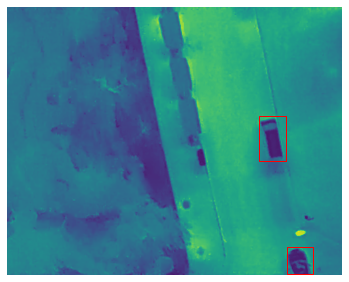

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

img, label = swim_dataset_test[5]
display_img_with_bbox(ax, img.permute(1, 2, 0), label)

model

In [8]:
from torchvision.models.detection.retinanet import RetinaNetHead
from torchvision.models.detection.retinanet import RetinaNet, _default_anchorgen
from torchvision.models.detection.anchor_utils import AnchorGenerator
from functools import partial
from torch import nn
from torchvision.models import swin_v2_s, Swin_V2_S_Weights

# def retina_swinv2(num_classes, weights_backbone=Swin_V2_S_Weights.IMAGENET1K_V1):
    
#     backbone = swin_v2_s(weights=weights_backbone)

#     anchor_generator = _default_anchorgen()

#     head = RetinaNetHead(
#         backbone.head.out_features,
#         anchor_generator.num_anchors_per_location()[0],
#         num_classes,
#         norm_layer=partial(nn.GroupNorm, 8),
#     )
#     head.regression_head._loss_type = "giou"
#     model = RetinaNet(backbone, num_classes, anchor_generator=anchor_generator, head=head)

#     return model

In [9]:
backbone = swin_v2_s(weights=Swin_V2_S_Weights.IMAGENET1K_V1);

Downloading: "https://download.pytorch.org/models/swin_v2_s-637d8ceb.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_s-637d8ceb.pth


  0%|          | 0.00/191M [00:00<?, ?B/s]

In [10]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn, retinanet_resnet50_fpn_v2, fcos_resnet50_fpn

def get_detect_model(num_classes, model_name="faster_rcnn", pretrained_head=False, pretrained_backbone=False):
    
    if model_name == "faster_rcnn":
        model = fasterrcnn_resnet50_fpn(
            num_classes = num_classes,
            pretrained = pretrained_head,
            pretrained_backbone = pretrained_backbone
        )
    
    # if model_name == "retina_net":
    #     model = retinanet_resnet50_fpn_v2(pretrained=pretrained)
        # model = retina_swinv2(num_classes)

    if model_name == "fcos_resnet":
        
        model = fcos_resnet50_fpn(
            num_classes = num_classes,
            pretrained = pretrained_head,
            pretrained_backbone = pretrained_backbone
            )

    return model

In [11]:
num_classes = 1+1

model = get_detect_model(
    num_classes = num_classes, 
    model_name = "faster_rcnn",
    pretrained_head = False,
    pretrained_backbone = True
)

inst_model = InstModel(
    model,
    "fast R-CNN",
    device
)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to pass

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

  0%|          | 0/502 [00:00<?, ?it/s]

Epoch: 0, Loss: 384.36932373046875


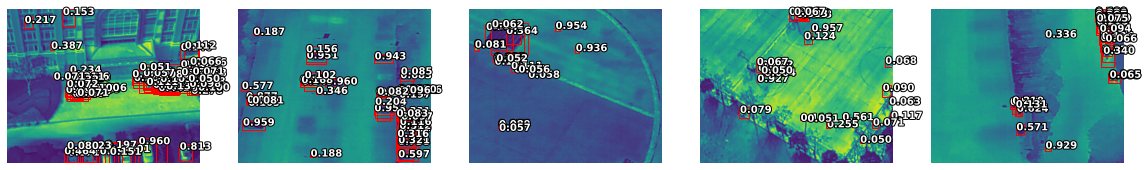

  0%|          | 0/502 [00:00<?, ?it/s]

Epoch: 1, Loss: 310.9415283203125


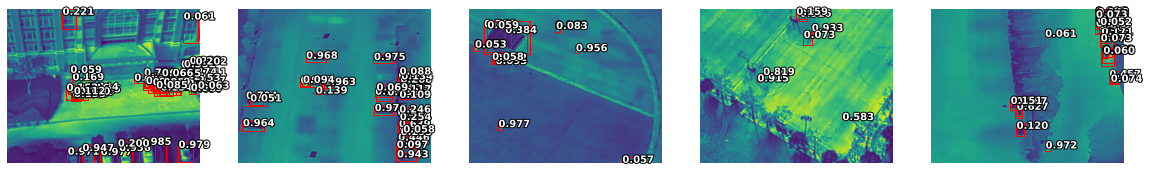

  0%|          | 0/502 [00:00<?, ?it/s]

Epoch: 2, Loss: 274.4078674316406


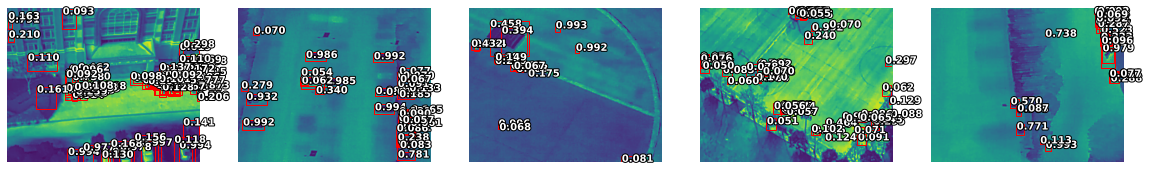

  0%|          | 0/502 [00:00<?, ?it/s]

Epoch: 3, Loss: 247.4360809326172


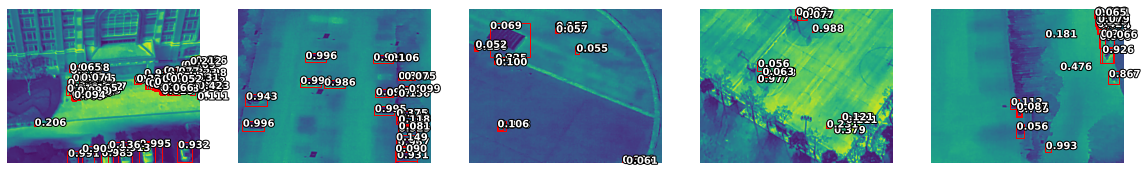

  0%|          | 0/502 [00:00<?, ?it/s]

Epoch: 4, Loss: 228.0849609375


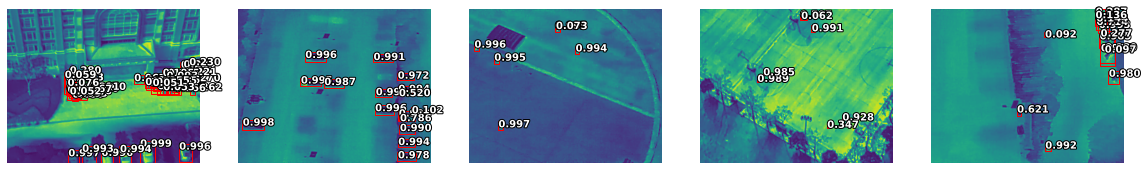

  0%|          | 0/502 [00:00<?, ?it/s]

Epoch: 5, Loss: 215.0224609375


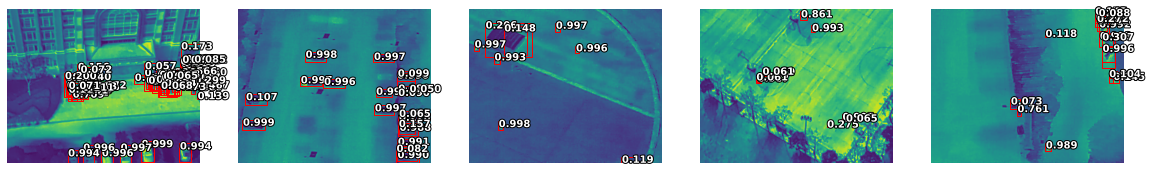

  0%|          | 0/502 [00:00<?, ?it/s]

Epoch: 6, Loss: 198.9044647216797


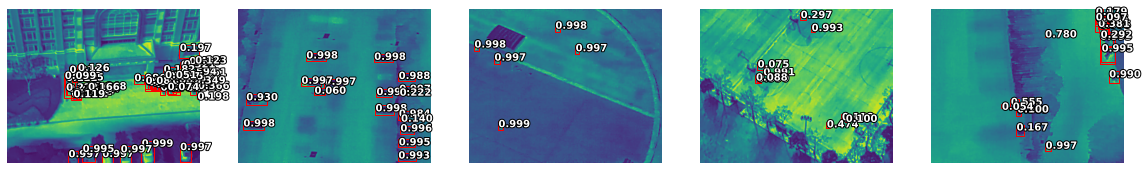

  0%|          | 0/502 [00:00<?, ?it/s]

Epoch: 7, Loss: 191.78146362304688


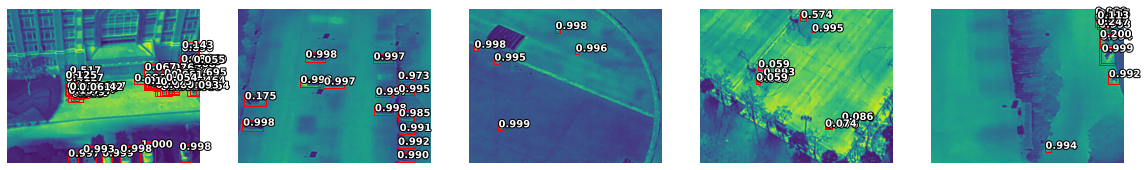

  0%|          | 0/502 [00:00<?, ?it/s]

Epoch: 8, Loss: 181.16854858398438


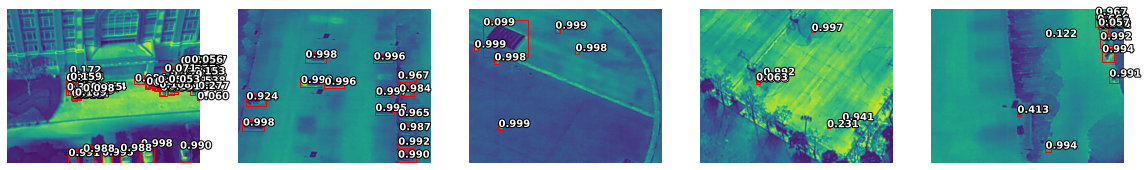

  0%|          | 0/502 [00:00<?, ?it/s]

Epoch: 9, Loss: 172.8765869140625


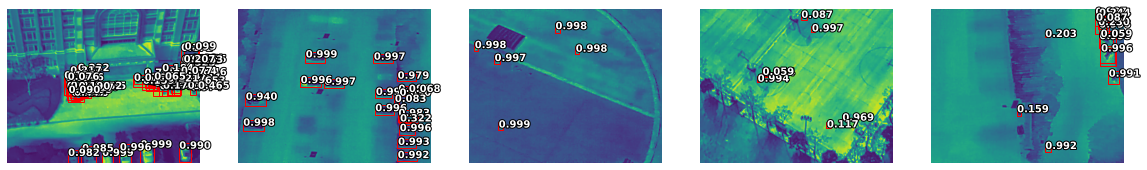

In [12]:
num_epochs = 10

inst_model.fit(
    epochs = num_epochs,
    train_loader = data_loader
)

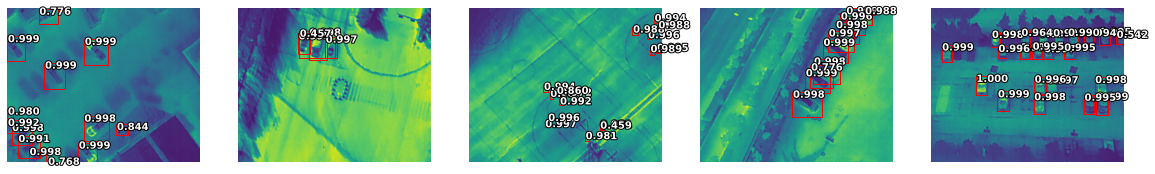

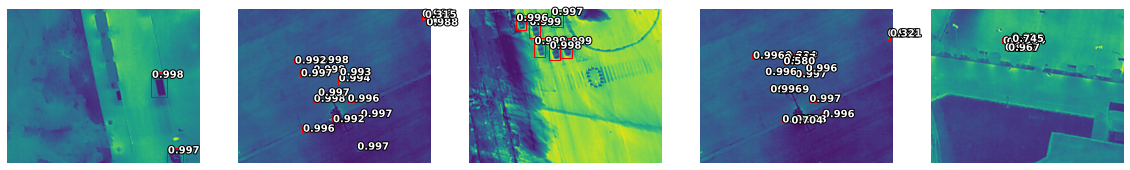

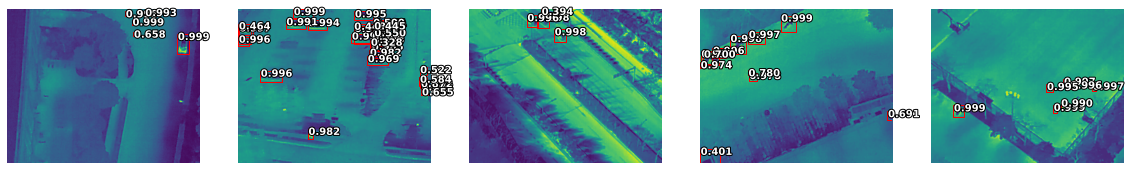

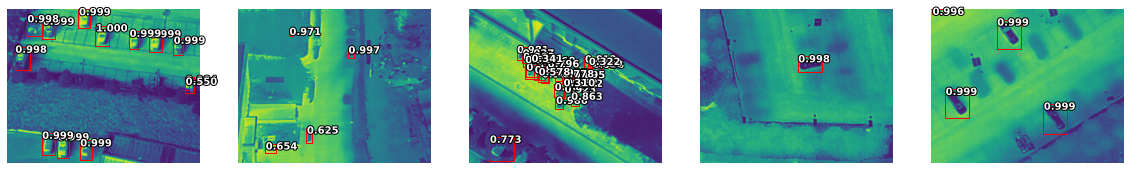

In [14]:
threshold = 0.3

inst_model.display_output(swim_dataset_test, [0,1,2,3,4], threshold)
inst_model.display_output(swim_dataset_test, [5,6,7,8,9], threshold)
inst_model.display_output(swim_dataset_test, [10,11,12,13,14], threshold)
inst_model.display_output(swim_dataset_test, [15,16,17,18,19], threshold)